data/testdata/output/data1.mat


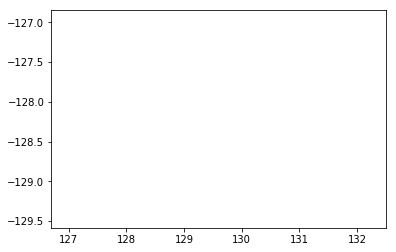

data/testdata/output/data2.mat


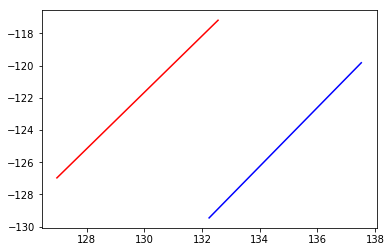

data/testdata/output/data3.mat


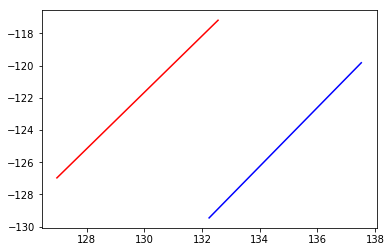

data/testdata/output/data4.mat


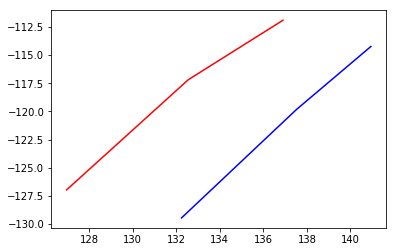

data/testdata/output/data5.mat


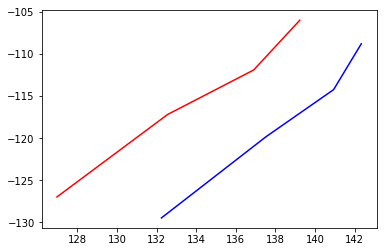

data/testdata/output/data6.mat


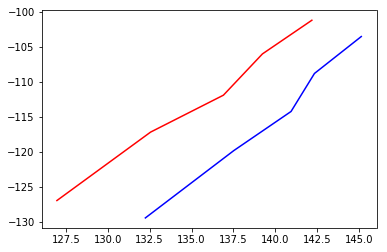

data/testdata/output/data7.mat


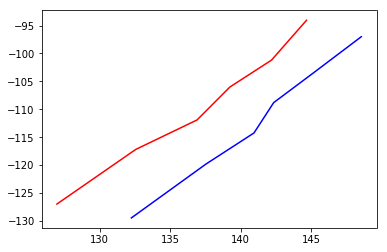

data/testdata/output/data8.mat


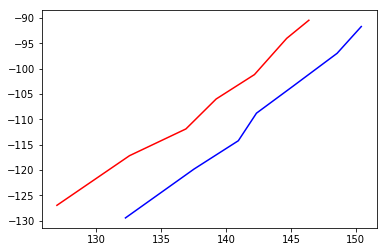

data/testdata/output/data9.mat


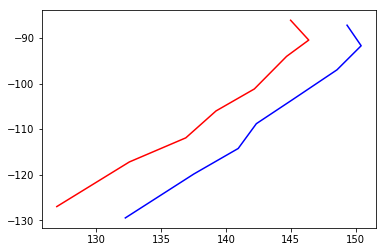

data/testdata/output/data10.mat


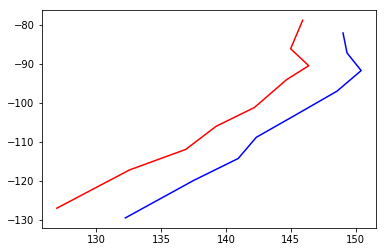

data/testdata/output/data11.mat


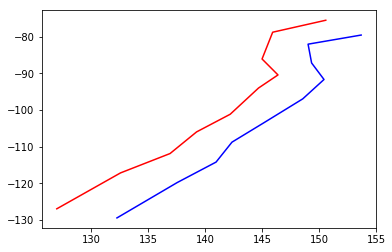

data/testdata/output/data12.mat


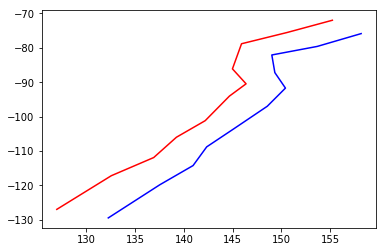

data/testdata/output/data13.mat


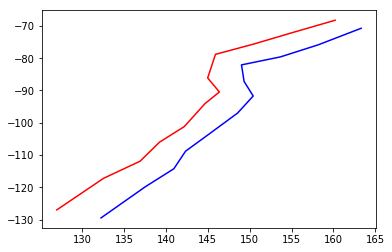

data/testdata/output/data14.mat


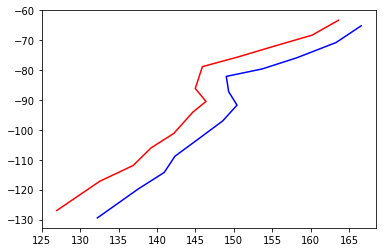

data/testdata/output/data15.mat


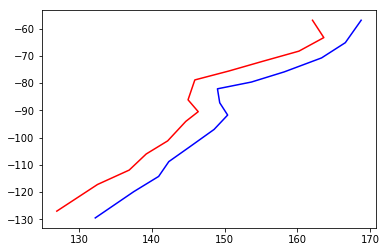

data/testdata/output/data16.mat


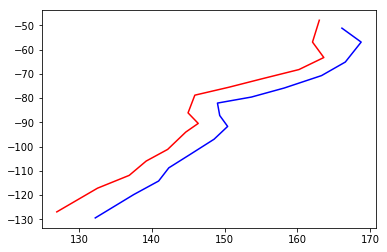

data/testdata/output/data17.mat


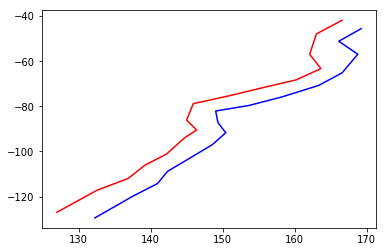

data/testdata/output/data18.mat


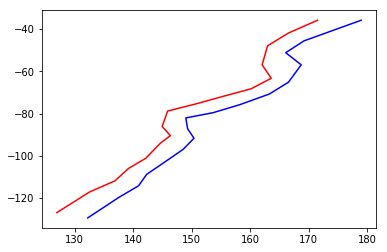

data/testdata/output/data19.mat


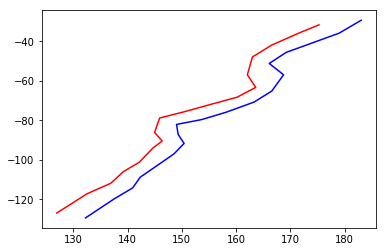

data/testdata/output/data20.mat


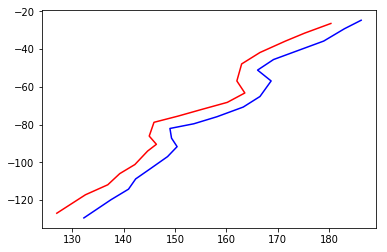

data/testdata/output/data21_sta.mat


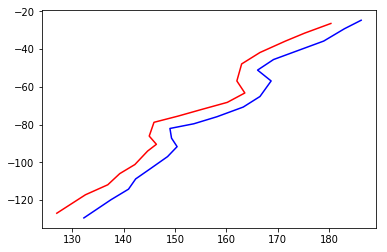

data/testdata/output/data22_sta.mat


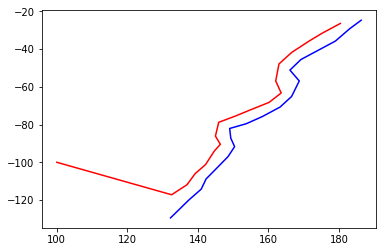

data/testdata/output/data23_sta.mat


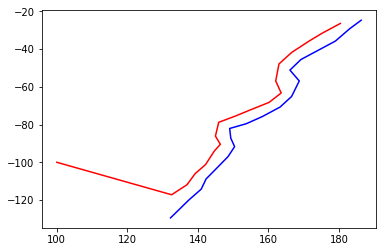

data/testdata/output/data24_sta.mat


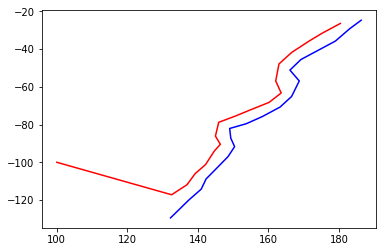

data/testdata/output/data25_sta.mat


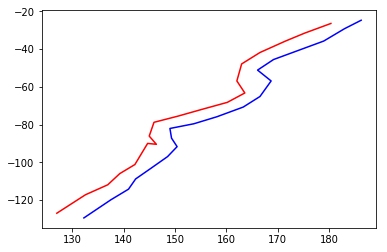

In [1]:
from math import *
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import copy
import os

#############################################################################################################################
## this track recognition function is operated by some evalation: distance, fitting line and so on

# get the data from .mat
def getdata(strt):
    print(strt)
    load_data = sio.loadmat(strt)
    left1 = load_data['left'] 
    right1 = load_data['right']
    position = load_data['position']
    a = position[0][0]
    b = position[0][1]
    position = [a,b]
    left = []
    right = []
    for i in range(len(left1)):
        left.append([])
        for j in range(len(left1[i])):
            left[i].append(left1[i][j])
    for i in range(len(right1)):
        right.append([])
        for j in range(len(right1[i])):
            right[i].append(right1[i][j])
    
    return left,right,position

# get the nummber from the Dataname

def numerical(str):
    num = ''
    get = False
    for i in range(len(str)):
        if str[i].isdigit():
            num = num + str[i]
            get = True
    if not get:
        numm = 999999
    else:
        numm = int(num)
    return numm


# find out wether this side of track has a big error
# the case that car recognize the cones from other track will only happen 
# when there is a corn, which means the distance between wrong cones and
# the average will be very large

# sort from the distance between the cones and the cars, or select the first cones with the line
# plan: plane[0]: distance between the origin and the line
#       plane[1]: winkel 
def sort_dis_find(position,measurements,method = 1,plane = [0,0]): # sort the cones by distance from the first cones
    # method == 1: sort with nearst line which made by both side of cones
    # method == 0: direct sort by distance
    ran = []
    ret = []
    nummber = 2 # the nummber of the cones I pick
    # first sort the cones with the distance from the car
    for j in range(len(measurements)):
        ran.append([])
        for i in range(len(measurements[j])):
            dx = measurements[j][i][0] - position[0]
            dy = measurements[j][i][1] - position[1]
            ran[j].append([])
            ran[j][i].append(sqrt(dx**2 + dy**2))
            for n in range(len(measurements[j][i])):
                ran[j][i].append(measurements[j][i][n])  
        ran[j].sort()
    if method: # method 1# find the first three cones of both side, selcet the cones, which minimize the distance 
        # between the cars and the lines
        left_min = []
        right_min = []
        for m in range(nummber):
            left_min.append([])
            right_min.append([])
            left_min[m].append(ran[0][m])
            right_min[m].append(ran[1][m])
        lines = []
        mc = 0
        for ml in range(nummber):
            for mr in range(nummber):
                lines.append([])
                dx = left_min[ml][0][1] - right_min[mr][0][1]
                dy = left_min[ml][0][2] - right_min[mr][0][2]
                winkel = atan2(dy,dx) + pi/2
                dphi = abs((left_min[ml][0][1]-position[0])*cos(winkel) + (left_min[ml][0][2] - position[1])*sin(winkel))
                lines[mc].append(dphi)
                lines[mc].append(winkel)
                lines[mc].append(ml)
                lines[mc].append(mr)
                mc = mc + 1
        lines.sort()
        plane[0] = lines[0][0]
        plane[1] = lines[0][1]
        
        # resort the cones with the selected starting cones
        for j in range(2):
            ren = ran
            for i in range(len(ren[j])):
                if i == lines[0][2+j]:
                    ren[j][i][0] = 0
            ren[j].sort()
            
        for n in range(2):
            ret.append([])
            for i in range(len(ren[n])):
                del ren[n][i][0]
                ret[n].append(ren[n][i])
    else:
        for n in range(2):
            ret.append([])
            for i in range(len(ran[n])):
                del ran[n][i][0]
                ret[n].append(ran[n][i])
                
        return ret[0],ret[1]

# sort the cones with defined beginning
def sort_dis_def(measurements,toler):
    
    sorte = []
    ret = []
# get the distance between each cone and the beginning cone
    for f in range(len(measurements)):
        sorte.append([])
        for i in range(len(measurements[f])):
            a = sqrt((measurements[f][i][0]-measurements[f][0][0])**2 + (measurements[f][i][1]-measurements[f][0][1])**2)
            sorte[f].append([a,measurements[f][i]])
            
# sort the cones
    for i in range(len(sorte)):
        a = sorte[i]
        a.sort()
        sorte[i] = a
        
# creat the return
    nobroken = True
    for f in range(len(sorte)):
        ret.append([])
        for i in range(len(sorte[f])-1):
            ret[f].append(sorte[f][i][1])
            if sqrt((sorte[f][i][1][0]-sorte[f][i+1][1][0])**2 + (sorte[f][i][1][1]-sorte[f][i+1][1][1])**2):
                break
                nobroken = False
        if nobroken:
            ret[f].append(sorte[f][i+1][1])
    
    return ret

# seperate the cones from the i-th
def seperate(i,cones):
    delect = []
    while i < len(cones):
        delect.append(cones[i])
        del cones[i]
        
    return cones,delect

# find out if there is a change for the position and delect the cones that are already detected in the past
def findchange(origin,new):
    change = []
    renew = []
    for i in range(len(new)):
        notsame = True
        for j in range(len(origin)):
            if new[i][2] == origin[j][2]:
                notsame = False
                if new[i][0] != origin[j][0] or new[i][1] != origin[j][1]:
                    origin[j][0] = new[i][0]
                    origin[j][1] = new[i][1]
                    change.append(j)
                break
        if notsame:
            renew.append(new[i])
                
    return origin,renew,change

# show the track
def showtrack(measurements):
    c = ['r','b']
    for j in range(len(measurements)):
        a = []
        b = []
        for i in range(len(measurements[j])):
            a.append(measurements[j][i][0])
            b.append(measurements[j][i][1])
        plt.plot(a, b, c = c[j%2])
        
    plt.show()

def track_rec(data,measurements,position,notfind,toler):
    [left,right,a] = data[0],data[1],data[2]
    position.append(a)
    
    if data[3] == 'sta':
        measurements = sta(measurements,[left,right],toler)

    elif len(measurements) == 0:
        measurements.append(left)
        measurements.append(right)
        
    elif notfind:
        if len(measurements[0]) >= 2 and len(measurements[1]) >= 2:
            measurements = sort_dis_find(position[0],measurements,0)
            notfind = False
        else : 
            [measurements[0],left,xx] = findchange(measurements[0],left)
            [measurements[1],right,xx] = findchange(measurements[1],right)
            measurements[0] = measurements[0] + left
            measurements[1] = measurements[1] + right
    
    else :
        measurements = list(measurements)
        [measurements[0],left,changeleft] = findchange(measurements[0],left)
        [measurements[1],right,changeright] = findchange(measurements[1],right)
        
    # give the previous cones to the new detected cones from the first changed position
        if len(changeleft) == 0:
            left1 = measurements[0][len(measurements[0])-1]
        else :
            [measurements[0],left1] = seperate(changeleft[0],measurements[0])
        if len(changeright) == 0:
            right1 = measurements[1][len(measurements[1])-1]
        else :
            [measurements[1],right1] = seperate(changeright[0],measurements[1])
        
        left = [left1] + left
        right = [right1] + right
        [left,right] = sort_dis_def([left,right], toler)
        measurements[0] = measurements[0] + left
        measurements[1] = measurements[1] + right
        
    return measurements,position,notfind

######### for the second round
# each input consist of two matrix: left and right, which includ the x,y,id
def sta(oldcones,newcones,toler):
    ret = oldcones
    check = newcones
    
    # add new cones
    for i in range(len(newcones)):
        for j in range(len(newcones[i])):
            have = False
            for n in range(len(ret[i])):
                if newcones[i][j][2] == ret[i][n][2]:
                    ret[i][n] = newcones[i][j]
                    have = True
                    break
            if have: 
                continue
            else:
                ret[i] = addnew(ret[i],newcones[i][j],toler)
                
    # delect the cones that not in newcones
    for i in range(len(ret)):
        delect = []
        for j in range(len(ret[i])):
            have = False
            for n in range(len(check[i])):
                if ret[i][j][2] == check[i][n][2]:
                    ret[i][j] = check[i][n]
                    have = True
                    break
            if have: 
                continue
            else:
                delect.append(j)
        if delect:
            for d in range(len(delect)):
                del ret[i][delect[d]-d]
    
    return ret

# the function that can add new cones into the old one and rerange it

def addnew(old,cone,toler):
    ret = old
    ret.append([0,0,0])
    distance = []
    # find the nearst cone
    for i in range(len(old)):
        distance.append([sqrt((old[i][0]-cone[0])**2 + (old[i][1]-cone[1])**2),i])
        
    distance.sort()
    index = distance[0][1]
    if index == 0 and sqrt((ret[1][0]-cone[0])**2 + (ret[1][1]-cone[1])**2) <= toler:
        rerange = [ret[0],ret[1],cone]
        rerange = sort_dis_def([rerange])
        for j in range(len(ret)-3):
            ret[len(ret)-j-1] = ret[len(ret)-j-2]
        for n in range(len(rerange)):
            ret[index-1+n] = rerange[n]
    elif  sqrt((ret[index-1][0]-cone[0])**2 + (ret[index-1][1]-cone[1])**2) <= toler\
            and sqrt((ret[index+1][0]-cone[0])**2 + (ret[index+1][1]-cone[1])**2) <= toler:
        rerange = [ret[index-1],ret[index],ret[index+1],cone]
        rerange = sort_dis_def([rerange])
        rerange = rerange[0]
        for j in range(len(ret)-index-3):
            ret[len(ret)-j-1] = ret[len(ret)-j-2]
        for n in range(len(rerange)):
            ret[index-1+n] = rerange[n]
    
    return ret

#############################################################################################################################
## test
#[left,right,position] = getdata('data\\testdata\\output\\data20')

#[left,right] = filt([left,right])

#showtrack([left,right])

# get data
files = os.listdir('data/testdata/output')
files = sorted(files,key=lambda s: numerical(s)) # read the data in the order of name

def publish():
    measurements = []
    position = []
    readlist = []
    notfind = True
    for file in files:
        if '.mat' in file and file not in readlist:
            data = getdata('data/testdata/output/'+file)
            data = list(data)
            readlist.append(file)
            if 'sta' in file:
                data.append('sta')
            else: 
                data.append('dyn')
            measurements,position,notfind = track_rec(data,measurements,position,notfind,10)
            showtrack(measurements)

publish()
    